## Loads

In [2]:
import sys
import os
script_dir = os.getcwd()
root_dir = os.path.join(os.path.dirname(os.path.abspath(script_dir)))
sys.path.append(root_dir)
os.chdir(root_dir)

In [3]:
os.getcwd()

'/home/helenajun/rag-llm-cancer-paper'

In [4]:
# !pip install rank_bm25
import json
import pandas as pd
import numpy as np
from utils.io import load_object, save_object
from utils.evaluation import calc_eval_metrics, get_avg_eval_runs, plot_radar_chart
from utils.check_db_version import get_local_version
import colorcet as cc
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import math

_VERSION=get_local_version()
_VERSION

'2025-09-04'

## Real-world query characteristics

In [5]:
real_world_query=pd.read_csv("data/real_world_db/real_world_db_split__v1.csv", index_col=0)
real_world_query['cancer_type']=real_world_query['cancer_type'].apply(ast.literal_eval)
real_world_query.head()

,prompt,cancer_category,cancer_type,biomarker,dataset
0,what is the first-line treatment of metastatic...,GU,"[urothelial carcinoma, metastatic]",['fgfr3'],test
1,are parp inhibitors used for patients with lei...,Sarcoma,[leiomyosarcoma],"['dna', 'parp']",test
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,[rhabdomyosarcoma],"['alk', 'tfcp2']",validation
3,for a patient with cancer metastatic prostate ...,GU,"[prostate cancer, cancer]",['brca2'],test
4,for a patient with her2+ breast cancer after n...,Breast,"[breast cancer, disease]",['her2'],test


### Standardize cancer names

In [6]:
real_world_query['cancer_type'].value_counts().keys()

Index([                                                                                                  [],
                                                                                          ['breast cancer'],
                                                                                         ['bladder cancer'],
                                                                                          ['neuroblastoma'],
                                                                                        ['prostate cancer'],
                                                                                      ['colorectal cancer'],
                                                                     ['urothelial carcinoma', 'metastatic'],
                                                                                     ['cholangiocarcinoma'],
                                                                         ['muscle-invasive bladder cancer'],
                   

In [44]:
cancer_mapping={
    'breast cancer':['breast cancer','lobular breast cancer','breast carcinoma'],
    'bladder cancer':['bladder cancer','urothelial carcinoma','muscle-invasive bladder cancer'],
    'neuroblastoma':['neuroblastoma','high-risk neuroblastoma'],
    'prostate cancer':['prostate cancer'],
    'colorectal cancer':['colorectal cancer','colo-rectal carcinoma','ascending colon adenocarcinoma','colon adenocarcinoma'],
    'cholangiocarcinoma':['cholangiocarcinoma','intrahepatic cholangiocarcinoma'],
    'lung cancer':['lung cancer','lung adenocarcinoma','non-small cell lung adenocarcinoma','non-small cell lung cancer','non small cell lung cancer'],
    'osteosarcoma':['osteosarcoma'],
    'thyroid cancer':['thyroid cancer','anaplastic thyroid cancer','medullary thyroid cancer'],
    'follicular lymphoma':['follicular lymphoma'],
    'hepatoblastoma':['hepatoblastoma'],
    'rhabdomyosarcoma':['rhabdomyosarcoma'],
    'nut midline carcinoma':['nut midline carcinoma'],
    'stomach cancer':['gastric adenocarcinoma','gastroesophageal junction adenocarcinoma'],
    'ovarian cancer':['high grade serious ovarian carcinoma'],
    'kidney cancer':['kidney cancer','clear-cell renal cell carcinoma tumor','clear-cell renal cell carcinoma','clear-cell kidney cancer'],
    'testicular cancer':['testicular cancer'],
    'biliary tract cancer':['biliary tract cancer'],
    'pancreatic cancer':['pancreatic cancer','pancreatic adenocarcinoma','pancreatic ductal adenocarcinoma'],
    'lymphoid neoplasms':['lymphoid neoplasms'],
    'desmoid tumors':['desmoid tumors'],
    'wilms tumor':['wilms tumor','high grade wilms tumor'],
    'peripheral nerve sheath tumor':['peripheral nerve sheath tumor'],
    'oligodendroglioma':['oligodendroglioma'],
    'melanoma':['melanoma'],
    'ewing sarcoma':['ewing sarcoma'],
    'acute myeloid leukemia':['acute myeloid leukemia'],
    'medulloblastoma':['medulloblastoma'],
    'leiomyosarcoma':['leiomyosarcoma'],
    'endometrial cancer':['endometrial carcinoma'],
    'b-cell acute lymphoblastic leukemia':['b-cell acute lymphoblastic leukemia','b-all'],
    'midline glioma':['midline glioma'],
    'anaplastic large cell lymphoma':['anaplastic large cell lymphoma']
}

In [40]:
real_world_query['standardized_cancer_type']=None
for k, v in cancer_mapping.items():
    for idx, c in enumerate(real_world_query['cancer_type']):
        if set(c).intersection(set(v)):
            real_world_query.at[idx, 'standardized_cancer_type']=k

In [43]:
for idx, row in real_world_query[real_world_query['standardized_cancer_type'].isna()].iterrows():
    print(row['prompt'])

for patients with advanced cancer and with ntrk fusions, regardless of cancer types, are there drugs approved?
for patients with advanced cancer and with high tmb, regardless of cancer types, are there drugs approved?
is there an optimal drug combination to minimize the risk of post hsct relapse in a 2 year old with kmt2a rearranged aml?
i have a patient with stage iii nsclc with an l858r mutation who was treated with chemoradiation and had a partial radiographic response. what are adjuvant therapy options? if there are multiple, what is the preferred option?
my metastatic cutaneous melanoma patient has high tmb and a braf mutation. what should i do?
i have a patient with radioactive iodine referactory thyroid cancer. what is the first line option?
for a patient with relapsed b-all that expresses cd22, what antibody-drug conjugates may be used?
for a patient with relapsed b-all that expresses cd19, what targeted treatment options exist?
what targeted treatment options exist for patient

In [ ]:
ner_missed_cancer=['unspecified',
 'unspecified',
 'acute myeloid leukemia',
 'lung cancer',
 'melanoma',
 'thyroid cancer',
 'b-cell acute lymphoblastic leukemia',
 'b-cell acute lymphoblastic leukemia',
 'acute myeloid leukemia',
 'midline glioma',
 'acute myeloid leukemia',
 'acute myeloid leukemia',
 'chronic lymphocytic leukemia',
 'unspecified',
 'colorectal cancer',
 'colorectal cancer',
 'cholangiocarcinoma',
 'anaplastic large cell lymphoma'
 ]

len(ner_missed_cancer)

In [59]:
ner_missed_idx=real_world_query[real_world_query['standardized_cancer_type'].isna()].index
real_world_query.loc[ner_missed_idx, "standardized_cancer_type"]=ner_missed_cancer

### Visualize cancer categories and types

Cancer category: cancer type grouped by its organ or system

In [166]:
counts=real_world_query['cancer_category'].value_counts()

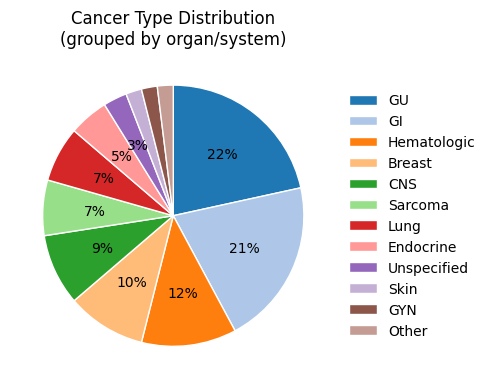

In [168]:
cols=sns.color_palette("tab20")
def autopct_func(pct):
    return f"{pct:.0f}%" if pct > 2 else ""  # only show if pct >= 3

fig, ax = plt.subplots(figsize=(5, 5))
wedges, _, autotexts = ax.pie(
    counts,
    autopct=autopct_func,
    startangle=90,
    counterclock=False,
    colors=cols,
    wedgeprops=dict(edgecolor='white')
)
for t in autotexts: 
    t.set_fontsize(10)
ax.legend(
    wedges, 
    counts.index, 
    # title='Cancer Type', 
    loc='center left', 
    bbox_to_anchor=(1,0.5),
    frameon=False
    )
plt.title("Cancer Type Distribution\n(grouped by organ/system)")
plt.tight_layout()
plt.show()

Cancer type: specific cancer types

In [148]:
counts=real_world_query['standardized_cancer_type'].value_counts()
n_unique=counts.keys().nunique()
n_unique

35

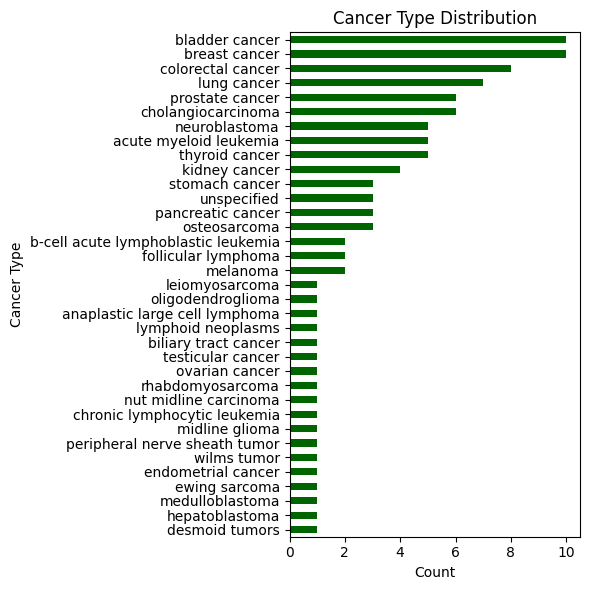

In [ ]:
counts[::-1].plot(
    kind="barh", 
    color="darkgreen",
    figsize=(6, 6)
    )
plt.xlabel("Count")
plt.ylabel("Cancer Type")
plt.title("Cancer Type Distribution")
plt.tight_layout()
plt.show()

In [181]:
real_world_query['dataset'].value_counts()

dataset
test          90
validation    12
Name: count, dtype: int64

## Real-world query validation

### Define evaluation metrics

In [ ]:
# Define evaluation keys
_METRICS = {
    "exact": "avg_exact_match_acc",
    "partial": "avg_partial_match_acc",
    "precision": "avg_precision",
    "recall": "avg_recall",
    "f1": "avg_f1",
    "specificity": "avg_specificity"
}

### Define evaluator

In [11]:
class Evaluator:
    def __init__(self, pipelines, strategies, metrics, query, true_dict, mode_paths, num_iter=1, subset_idx=None):
        """
        pipelines: list of pipelines ('RAG' for rag-llm or 'LLM' for llm-only)
        strategies: str (e.g., "0" for basic prompt or "5" for scope-defined prompt)
        mode_paths: dict of {mode_name: base_filepath}
        Example: {
            "dense": _DENSE_FILEPATH,
            "hybrid": _HYBRID_FILEPATH
        }
        """
        if isinstance(pipelines, str):
            pipelines = [pipelines]
            
        self.pipelines = pipelines
        self.strategies = strategies
        self.metrics = metrics
        self.true_dict = true_dict
        self.mode_paths = mode_paths
        self.num_iter = num_iter
        self.subset_idx = subset_idx
        
        # Subset queries if provided
        if self.subset_idx is not None:
            self.query = query.iloc[self.subset_idx]
        else:
            self.query = query
        
        # Initialize results for all pipelines and modes
        self.results = { 
            pipeline: {
                mode: {m: {s: [] for s in strategies} for m in metrics}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }
        
        self.evals = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }
        
        self.llm_input = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }
        
        self.llm_output = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }
        
        self.retrieval = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths
                }
            for pipeline in self.pipelines
        }

    def evaluate_strategy(self, pipeline, mode):
        base_path = self.mode_paths[mode]
        for s in self.strategies:
            filepath = os.path.join(base_path, f"{pipeline}stra{s}n{self.num_iter}temp0.0_res_dict.pkl")
            obj = load_object(filepath)
            
            for i in range(self.num_iter):
                try:
                    input_prompt = obj["input prompt"][i]
                    full_output = obj["full output"][i]
                    retrieval_output = obj["retrieval"][i]
                    
                    if self.subset_idx is not None:
                        input_prompt_subset = [input_prompt[j] for j in self.subset_idx]
                        full_output_subset = [full_output[j] for j in self.subset_idx]
                        retrieval_subset = [retrieval_output[j] for j in self.subset_idx]
                    else:
                        input_prompt_subset = input_prompt
                        full_output_subset = full_output
                        retrieval_subset = retrieval_output
                        
                    eval_dict = calc_eval_metrics(
                        full_output_subset,
                        self.query["prompt"].tolist(),
                        self.true_dict
                    )
                    self.evals[pipeline][mode][s].append(eval_dict)
                    self.llm_input[pipeline][mode][s].append(input_prompt_subset)
                    self.llm_output[pipeline][mode][s].append(full_output_subset)
                    self.retrieval[pipeline][mode][s].append(retrieval_subset)
                    for name, key in self.metrics.items():
                        self.results[pipeline][mode][name][s].append(eval_dict[key])
                except Exception:
                    continue

    def run(self):
        for pipeline in self.pipelines:
            for mode in self.mode_paths:
                self.evaluate_strategy(pipeline, mode)

    def average(self):
        average = {}
        for pipeline in self.pipelines:
            average[pipeline] = {}
            for mode in self.mode_paths:
                average[pipeline][mode] = {
                    m: {s: np.mean(vals) if vals else None for s, vals in strat.items()}
                    for m, strat in self.results[pipeline][mode].items()
                }
        return average


### Dense vs. Hybrid

In [12]:
num_iter = 5
strategies = ["5"]
_PIPELINE='RAG'
_DENSE_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_val_v2_dense'
_HYBRID_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_val_v2_hybrid'
_QUERY_VAL = pd.read_csv(f"data/real_world_db/real_world_validation__v2.csv", index_col=0)
_QUERY_TRUE = load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")

mode_paths = {
    "dense": _DENSE_FILEPATH,
    "hybrid": _HYBRID_FILEPATH
}

evaluator_val_queries = Evaluator(
    pipelines=_PIPELINE,
    strategies=strategies,
    metrics=_METRICS,
    query=_QUERY_VAL,
    true_dict=_QUERY_TRUE,
    mode_paths=mode_paths,
    num_iter=num_iter
)

In [13]:
evaluator_val_queries.run()
average = evaluator_val_queries.average()

In [81]:
val_queries_results=evaluator_val_queries.results['RAG']
val_queries_average=average['RAG']
val_queries_average

{'dense': {'exact': {'5': 0.7047619047619047},
  'partial': {'5': 0.8952380952380953},
  'precision': {'5': 0.8466666666666665},
  'recall': {'5': 0.6566666666666667},
  'f1': {'5': 0.71},
  'specificity': {'5': 0.9994318181818181}},
 'hybrid': {'exact': {'5': 0.7523809523809524},
  'partial': {'5': 0.9238095238095239},
  'precision': {'5': 0.915},
  'recall': {'5': 0.7566666666666667},
  'f1': {'5': 0.7999999999999999},
  'specificity': {'5': 0.9994318181818181}}}

In [15]:
def compare_mode_A_vs_B(A_failed, B_failed):
    both_success, both_failed, A_failed_B_success, A_success_B_failed = 0, 0, 0, 0
    
    for A_fail, B_fail in zip(A_failed, B_failed):
        if A_fail and B_fail:
            both_failed += 1
        elif A_fail and not B_fail:
            A_failed_B_success += 1
        elif not A_fail and B_fail:
            A_success_B_failed += 1
        else:
            both_success += 1
    return [both_success, A_success_B_failed,
            A_failed_B_success, both_failed]

def compare_mode_A_vs_B_idx(A_failed, B_failed):
    both_success, both_failed, A_failed_B_success, A_success_B_failed = [], [], [], []
    for i, (A_fail, B_fail) in enumerate(zip(A_failed, B_failed)):
        if A_fail and B_fail:
            both_failed.append(i)
        elif A_fail and not B_fail:
            A_failed_B_success.append(i)
        elif not A_fail and B_fail:
            A_success_B_failed.append(i)
        else:
            both_success.append(i)
    return {
        "both_success": both_success,
        "both_failed": both_failed,
        "A_failed_B_success": A_failed_B_success,
        "A_success_B_failed": A_success_B_failed
    }

In [100]:
unique_biomarkers=real_world_query['biomarker'].drop_duplicates()
unique_biomarkers_ls=[]
for biomarker in unique_biomarkers:
    biomarkers=ast.literal_eval(biomarker)
    for b in biomarkers:
        if b not in unique_biomarkers_ls:
            unique_biomarkers_ls.append(b)

In [101]:
exclude=['ihc 1','nsclc','aml','fda','parp','dna','hormone','bcs']
syns={
    'er':['estrogen receptor'],
    'hr':['hormone receptor'],
    'braf v600e':['brafv600e'],
}

In [102]:
biomarkers={k if b in v else b for k, v in syns.items() for b in unique_biomarkers_ls}
for i in exclude:
    biomarkers.remove(i)

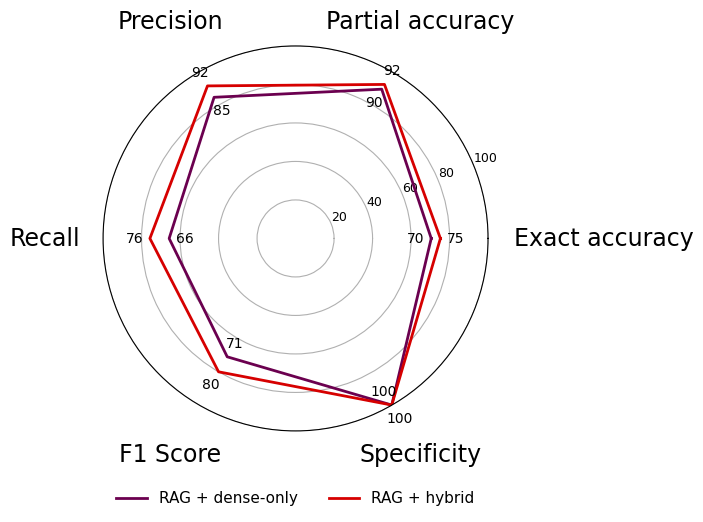

In [112]:
cols = sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(_METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_results = {
    'RAG + dense-only': {k: v['5']*100 for k, v in val_queries_average['dense'].items()},
    'RAG + hybrid': {k: v['5']*100 for k, v in val_queries_average['hybrid'].items()},
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title=None,
    colors=[cols[6],cols[0]]
    )

Analyze failures:
- Are errors due to retrieval (recall of relevant contexts), reasoning (does the LLM use the retrieved info correctly?), or both?

Categorize errors:
- Retrieval failure (missing context)
- Hallucination (LLM generates unsupported facts)
- Misinterpretation or misattribution (LLM misuses retrieved evidence)

#### Partial match error analysis results



In [ ]:
all_results_idx = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_val_queries.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(dense_partial_failed, hybrid_partial_failed))
all_results_idx

In [121]:
for i in range(5):
    idx=all_results_idx[i]['both_failed']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {evaluator_val_queries.query['prompt'][j]}")
        print("============= ground-truth =============")
        print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        # print("============= dense =============")
        # print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_val_queries.llm_output['RAG']['dense']['5'][i][j])
        # print(evaluator_val_queries.llm_input['RAG']['dense']['5'][i][j])
        # print("============= hybrid =============")
        # print(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_val_queries.llm_output['RAG']['hybrid']['5'][i][j])
        # print(evaluator_val_queries.llm_input['RAG']['hybrid']['5'][i][j])
        # print(evaluator_val_queries.retrieval['RAG']['hybrid']['5'][i][j]['retrieval_results'][0]['retrieved_df'])

============= query =============
(0, 7): what fda-approved therapies exist for a stage iv pancreatic ductal adenocarcinoma patient with a ntrk mutation
============= ground-truth =============
{frozenset({'repotrectinib'}), frozenset({'larotrectinib'}), frozenset({'entrectinib'})}
============= query =============
(0, 14): is there an optimal drug combination to minimize the risk of post hsct relapse in a 2 year old with kmt2a rearranged aml?
============= ground-truth =============
set()
============= query =============
(1, 7): what fda-approved therapies exist for a stage iv pancreatic ductal adenocarcinoma patient with a ntrk mutation
============= ground-truth =============
{frozenset({'repotrectinib'}), frozenset({'larotrectinib'}), frozenset({'entrectinib'})}
============= query =============
(1, 14): is there an optimal drug combination to minimize the risk of post hsct relapse in a 2 year old with kmt2a rearranged aml?
============= ground-truth =============
set()
==========

In [118]:
for i in range(5):
    idx=all_results_idx[i]['A_failed_B_success']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {evaluator_val_queries.query['prompt'][j]}")
        print("============= ground-truth =============")
        print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        # print("============= dense =============")
        # print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_val_queries.llm_output['RAG']['dense']['5'][i][j])
        # print(evaluator_val_queries.llm_input['RAG']['dense']['5'][i][j])
        # print("============= hybrid =============")
        # print(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_val_queries.llm_output['RAG']['hybrid']['5'][i][j])
        # print(evaluator_val_queries.llm_input['RAG']['hybrid']['5'][i][j])
        # print(evaluator_val_queries.retrieval['RAG']['hybrid']['5'][i][j]['retrieval_results'][0]['retrieved_df'])

============= query =============
(2, 7): what fda-approved therapies exist for a stage iv pancreatic ductal adenocarcinoma patient with a ntrk mutation
============= ground-truth =============
{frozenset({'repotrectinib'}), frozenset({'larotrectinib'}), frozenset({'entrectinib'})}
============= query =============
(3, 7): what fda-approved therapies exist for a stage iv pancreatic ductal adenocarcinoma patient with a ntrk mutation
============= ground-truth =============
{frozenset({'repotrectinib'}), frozenset({'larotrectinib'}), frozenset({'entrectinib'})}
============= query =============
(4, 0): what is the first-line treatment of metastatic urothelial carcinoma with fgfr3 s249c mutation?
============= ground-truth =============
{frozenset({'erdafitinib'})}


Both failed:
- 7: context retrieved, LLM answer incorrect -> hybrid gets it right, but not always \
- 14: context retrieved, LLM answer incorrect -> isn't LLM correct? revumenib looks like the right answer?

Dense failed Hybrid success:
7, 0 (although not consistently across all runs)

Dense success hybrid failed:
None

#### Exact match error analysis results

In [122]:
all_results_idx = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_val_queries.evals['RAG']['dense']['5'][i]['exact_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['exact_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(dense_partial_failed, hybrid_partial_failed))
all_results_idx

[{'both_success': [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 20],
  'both_failed': [3, 7, 14, 17, 18],
  'A_failed_B_success': [19],
  'A_success_B_failed': []},
 {'both_success': [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 20],
  'both_failed': [3, 7, 14, 17, 18, 19],
  'A_failed_B_success': [],
  'A_success_B_failed': []},
 {'both_success': [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 20],
  'both_failed': [3, 14, 17, 18],
  'A_failed_B_success': [7, 19],
  'A_success_B_failed': []},
 {'both_success': [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 20],
  'both_failed': [3, 14, 17, 18, 19],
  'A_failed_B_success': [7],
  'A_success_B_failed': []},
 {'both_success': [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 20],
  'both_failed': [3, 7, 14, 17, 18, 19],
  'A_failed_B_success': [0],
  'A_success_B_failed': []}]

In [ ]:
for i in range(5):
    idx=all_results_idx[i]['both_failed']
    for j in idx:
        if j == 18:
            print("============= query =============")
            print(f"{i,  j}: {evaluator_val_queries.query['prompt'][j]}")
            print("============= ground-truth =============")
            print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
            print("============= dense =============")
            print(evaluator_val_queries.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
            # print(evaluator_val_queries.llm_output['RAG']['dense']['5'][i][j])
            # print(evaluator_val_queries.llm_input['RAG']['dense']['5'][i][j])
            print("============= hybrid =============")
            print(evaluator_val_queries.evals['RAG']['hybrid']['5'][i]['pred_drugs_generic_set_ls'][j])
            print(evaluator_val_queries.llm_output['RAG']['hybrid']['5'][i][j])
            print(evaluator_val_queries.llm_input['RAG']['hybrid']['5'][i][j])
            print(evaluator_val_queries.retrieval['RAG']['hybrid']['5'][i][j]['retrieval_results'][0]['retrieved_df'])
    break

Both failed:
- 3: context retrieved incomplete (e.g., missing prednisolone + abiraterone acetate + niraparib)
- 7: same reason as above
- 14: same reason as above
- 17: context retrieved -> llm retrieval failed
- 18: 
- 19:

## Real-world query evaluation

### Define evaluation metrics

In [6]:
# Define evaluation keys
_METRICS = {
    "exact": "avg_exact_match_acc",
    "partial": "avg_partial_match_acc",
    "precision": "avg_precision",
    "recall": "avg_recall",
    "f1": "avg_f1",
    "specificity": "avg_specificity"
}

### Dense-only vs. Hybrid

In [215]:
num_iter = 5
strategies = ["5"]
_PIPELINE='RAG'
_DENSE_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_test_v2_dense'
_HYBRID_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_test_v2_hybrid'
_QUERY_TEST = pd.read_csv(f"data/real_world_db/real_world_test__v2.csv", index_col=0)
_QUERY_TRUE = load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")

mode_paths = {
    "dense": _DENSE_FILEPATH,
    "hybrid": _HYBRID_FILEPATH
}

evaluator_all_queries = Evaluator(
    pipelines=_PIPELINE,
    strategies=strategies,
    metrics=_METRICS,
    query=_QUERY_TEST,
    true_dict=_QUERY_TRUE,
    mode_paths=mode_paths,
    num_iter=num_iter
)

In [216]:
evaluator_all_queries.run()
average = evaluator_all_queries.average()

In [217]:
all_queries_results=evaluator_all_queries.results['RAG']
all_queries_average=average['RAG']

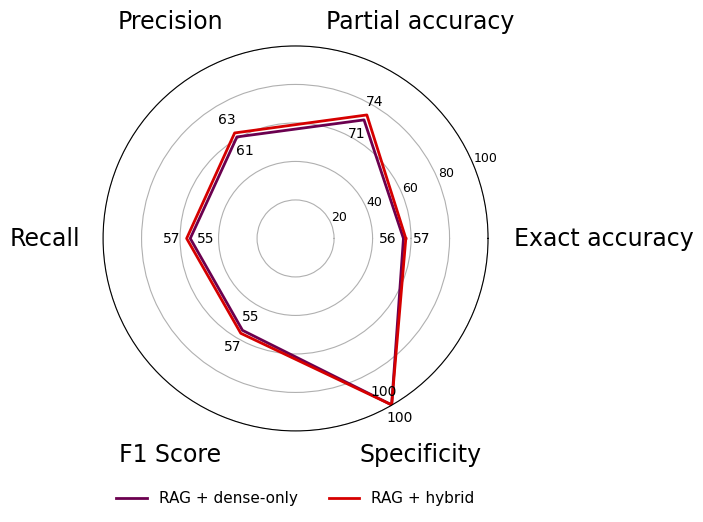

In [220]:
cols = sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(_METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_results = {
    'RAG + dense-only': {k: v['5']*100 for k, v in all_queries_average['dense'].items()},
    'RAG + hybrid': {k: v['5']*100 for k, v in all_queries_average['hybrid'].items()},
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title=None,
    colors=[cols[6],cols[0]]
    )

### Group queries
- All vs. Queries within scope (asking biomarker-associated, FDA approved drugs)
- Including single biomarker vs. multiple biomarkers vs. biomarkers with unknown significance
- Queries within scope vs. tumor-agnostic queries

In [221]:
_QUERY_RAW=pd.read_csv(f"data/real_world_db/updated_real_world_queries_answers__v1.csv")
_QUERY_RAW=_QUERY_RAW.dropna(subset='Questions').reset_index(drop=True)

query_in_scope=_QUERY_RAW[
    (_QUERY_RAW['Asking_genomic_biomarker_linked_therapy']==True) &
    (_QUERY_RAW['Asking_therapy']==True)
    ].index.tolist()

query_multiple_biomarkers=_QUERY_RAW[
    (_QUERY_RAW['Asking_genomic_biomarker_linked_therapy']==True) &
    (_QUERY_RAW['Asking_therapy']==True) &
    (_QUERY_RAW['Multiple_biomarkers']==True)
    ].index.tolist()

In [222]:
# add boolean columns to group queries
_QUERY_TEST.loc[_QUERY_TEST.index.isin(query_in_scope), 'within_scope']=True
_QUERY_TEST.loc[_QUERY_TEST.index.isin(query_multiple_biomarkers), 'multiple_biomarkers']=True

#### All queries (n=90) vs. Queries within scope (n=83)

In [223]:
# get appropriate indices
_QUERY_TEST_REINDEXED=_QUERY_TEST.reset_index()
within_scope_ind=_QUERY_TEST_REINDEXED[
    _QUERY_TEST_REINDEXED['index']
    .isin(_QUERY_TEST[_QUERY_TEST['within_scope']==True].index)
    ].index.tolist()

In [224]:
num_iter = 5
strategies = ["5"]
_PIPELINE='RAG'

mode_paths = {
    "dense": _DENSE_FILEPATH,
    "hybrid": _HYBRID_FILEPATH
}

evaluator_within_scope_queries = Evaluator(
    pipelines=_PIPELINE,
    strategies=strategies,
    metrics=_METRICS,
    query=_QUERY_TEST_REINDEXED,
    true_dict=_QUERY_TRUE,
    mode_paths=mode_paths,
    num_iter=num_iter,
    subset_idx=within_scope_ind
)

In [225]:
evaluator_within_scope_queries.run()
average = evaluator_within_scope_queries.average()

In [226]:
within_scope_queries_results=evaluator_within_scope_queries.results['RAG']
within_scope_queries_average=average['RAG']

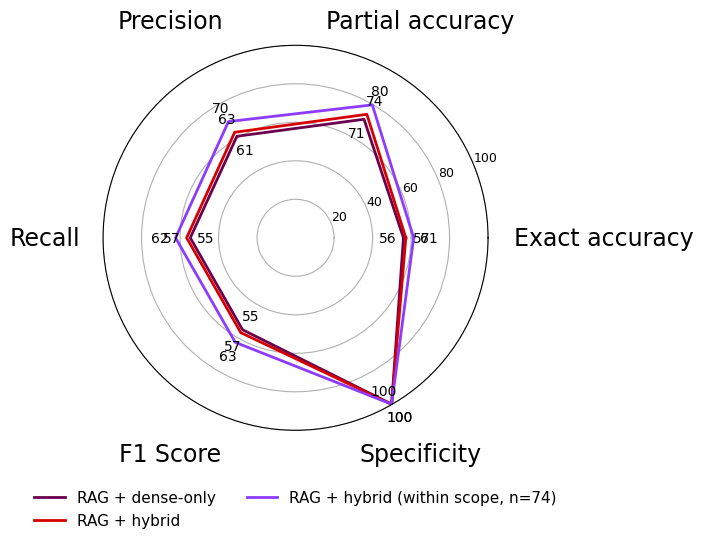

In [234]:
cols=sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(_METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

n = _QUERY_TEST_REINDEXED.loc[within_scope_ind].shape[0]
plot_results = {
    'RAG + dense-only': {k: v['5']*100 for k, v in all_queries_average['dense'].items()},
    'RAG + hybrid': {k: v['5']*100 for k, v in all_queries_average['hybrid'].items()},
    f'RAG + hybrid (within scope, {n=})': {k: v['5']*100 for k, v in within_scope_queries_average['hybrid'].items()}
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title=None,
    colors=[cols[6],cols[0],cols[1]]
    )

### Inspect success and failed cases in dense-only search vs. hybrid search

In [235]:
_QUERY_SCOPE=_QUERY_TEST_REINDEXED.loc[within_scope_ind]
_QUERY_SCOPE.reset_index(inplace=True)
_QUERY_SCOPE.rename(columns={'level_0':'test_query_index','index':'all_query_index'}, inplace=True)

In [236]:
all_results = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['hybrid']['5'][i]['partial_match_acc'])
    all_results.append(compare_mode_A_vs_B(dense_partial_failed, hybrid_partial_failed))

arr = np.array(all_results)

summary = pd.DataFrame({
    "Both Success": arr[:,0],
    "Dense Success and Hybrid Failed": arr[:,1],
    "Dense Failed and Hybrid Success": arr[:,2],
    "Both Failed": arr[:,3]
})

summary_stats = summary.agg(['mean', 'std']).T
print(summary_stats)


                                 mean       std
Both Success                     56.0  0.707107
Dense Success and Hybrid Failed   0.6  0.894427
Dense Failed and Hybrid Success   3.0  0.707107
Both Failed                      14.4  1.140175


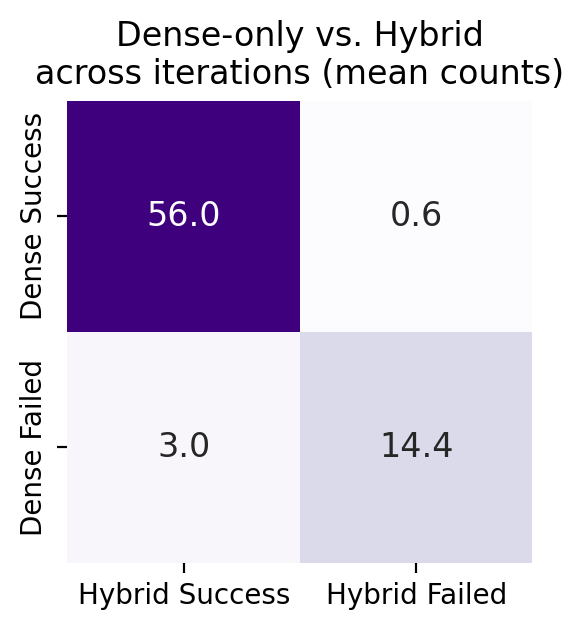

In [237]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

avg_cm = np.array([
    [summary_stats.loc["Both Success","mean"], summary_stats.loc["Dense Success and Hybrid Failed","mean"]],
    [summary_stats.loc["Dense Failed and Hybrid Success","mean"], summary_stats.loc["Both Failed","mean"]]
])
sns.heatmap(avg_cm, annot=True, annot_kws={"fontsize": 12},
            fmt=".1f", cmap="Purples", cbar=False,
            xticklabels=["Hybrid Success", "Hybrid Failed"],
            yticklabels=["Dense Success", "Dense Failed"])
plt.title("Dense-only vs. Hybrid\nacross iterations (mean counts)")
plt.show()

In [243]:
all_results_idx = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['hybrid']['5'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(dense_partial_failed, hybrid_partial_failed))

In [248]:
for i in range(5):
    idx=all_results_idx[i]['both_failed']
    for j in idx:
        print(j)
        print("============= dense =============")
        print(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
        print("============= hybrid =============")
        print(evaluator_within_scope_queries.evals['RAG']['hybrid']['5'][i]['pred_drugs_generic_set_ls'][j])
        print("============= ground-truth =============")
        print(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
    break

11
============= dense =============
{frozenset({'pembrolizumab'})}
============= hybrid =============
set()
============= ground-truth =============
{frozenset({'cabozantinib', 'nivolumab'}), frozenset({'pembrolizumab', 'lenvatinib'}), frozenset({'ipilimumab', 'nivolumab'}), frozenset({'axitinib', 'avelumab'}), frozenset({'axitinib', 'pembrolizumab'})}
13
============= dense =============
{frozenset({'erdafitinib'})}
============= hybrid =============
{frozenset({'erdafitinib'})}
============= ground-truth =============
{frozenset({'enfortumab vedotin'})}
19
============= dense =============
set()
============= hybrid =============
set()
============= ground-truth =============
{frozenset({'cabozantinib'})}
23
============= dense =============
set()
============= hybrid =============
set()
============= ground-truth =============
{frozenset({'doxorubicin'}), frozenset({'cisplatin'}), frozenset({'methotrexate'})}
26
============= dense =============
{frozenset({'midostaurin', 'cytarabi

Drug indication not linked to a biomarker: 19, 23 

In [238]:
all_results = []
for i in range(5): 
    dense_exact_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['dense']['5'][i]['exact_match_acc'])
    hybrid_exact_failed = ~np.array(evaluator_within_scope_queries.evals['RAG']['hybrid']['5'][i]['exact_match_acc'])
    all_results.append(compare_mode_A_vs_B(dense_exact_failed, hybrid_exact_failed))

arr = np.array(all_results)

summary = pd.DataFrame({
    "Both Success": arr[:,0],
    "Dense Success and Hybrid Failed": arr[:,1],
    "Dense Failed and Hybrid Success": arr[:,2],
    "Both Failed": arr[:,3]
})

summary_stats = summary.agg(['mean', 'std']).T
print(summary_stats)


                                 mean       std
Both Success                     43.6  0.547723
Dense Success and Hybrid Failed   0.8  0.836660
Dense Failed and Hybrid Success   1.8  0.447214
Both Failed                      27.8  1.095445


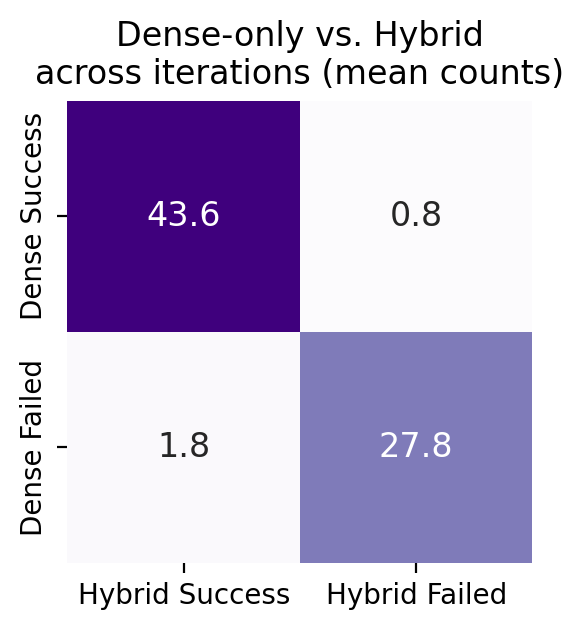

In [239]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

avg_cm = np.array([
    [summary_stats.loc["Both Success","mean"], summary_stats.loc["Dense Success and Hybrid Failed","mean"]],
    [summary_stats.loc["Dense Failed and Hybrid Success","mean"], summary_stats.loc["Both Failed","mean"]]
])
sns.heatmap(avg_cm, annot=True, annot_kws={"fontsize": 12},
            fmt=".1f", cmap="Purples", cbar=False,
            xticklabels=["Hybrid Success", "Hybrid Failed"],
            yticklabels=["Dense Success", "Dense Failed"])
plt.title("Dense-only vs. Hybrid\nacross iterations (mean counts)")
plt.show()

### Edge cases or rare cases analysis